# Statistical Analysis of Polygon characteristics across a stream in McMurdo Dry Valleys
**Methods:** 
 - Divide mapped region into grid
 - Calculate common statistics for Polygons within each grid cell
 - Calculate intersection style and angles within each grid cell

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from rasterio.transform import AffineTransformer
import geopandas as gpd
import pandas as pd
from apdt.stats import calculate_intersection_angles
from apdt.pre_processing import import_raw_dem
import shapely.geometry as geom

In [12]:
def transform_geometry(geometry,transformer):
    def trans_it(x,y):
        yt,xt = transformer.rowcol(xs=x,ys=y)
        points = list(zip(xt,yt))
        return points


    if type(geometry) == geom.polygon.Polygon:
        x,y = geometry.boundary.coords.xy
        trans_geometry = geom.Polygon(trans_it(x,y))
    elif type(geometry) == geom.linestring.LineString:
        x,y = geometry.coords.xy
        trans_geometry = geom.LineString(trans_it(x,y))
    elif type(geometry) == geom.point.Point:
        x,y = geometry.coords.xy
        trans_geometry = geom.Point(trans_it(x,y))
    
    return trans_geometry

In [128]:
# Load in DEM and mapped Polygons
dem_path = 'DEMs/70-81_clipStream.tif'
path_in = 'Outputs/EastValley/70-87_clipSouth_'
path_figs = 'FIGURES/South_'

dem, trans_mat, crs = import_raw_dem(dem_path)
transformer = AffineTransformer(trans_mat)

poly_gdf = gpd.read_file(path_in+'Polygons')
poly_list = [transform_geometry(p,transformer) for p in poly_gdf['geometry']]

the minimum raster value:  321.2753
the maximum raster value:  417.9084
0.5th percentile:  324.41666229248045
1st percentile:  325.4610653686523
5th percentile:  328.31048583984375
50th percentile:  342.9844055175781
75th percentile:  355.631591796875
90th percentile:  370.5914642333984
95th percentile:  381.4447937011719
99.99th percentile:  416.64740344543435
99.991th percentile:  416.68496138244626
99.995th percentile:  416.72032447021485
99.999th percentile:  417.4212129251098


In [114]:
trough_gdf = gpd.read_file(path_in+'Troughs')
trough_list = [transform_geometry(p,transformer) for p in trough_gdf['geometry']]

node_gdf = gpd.read_file(path_in+'Nodes')
node_list = [transform_geometry(n,transformer) for n in node_gdf['geometry']]

# recreate edges list for graphing:
edges = []
for trough in trough_list:
    x,y = trough.xy
    start = geom.Point((x[0],y[0]))
    stop = geom.Point((x[-1],y[-1]))
    edges.append({'start':start,'stop':stop,'path':trough})


## Size & Shape
Calculate Area, size, Length/Width, Aspect Ratio

In [124]:
def cart_distance(x1,x2,y1,y2):
    return np.sqrt((x1-x2)**2 + (y1-y2)**2)

def calculate_stats(polygons):
    df = pd.DataFrame(columns=['Area_m2','Width_m','Length_m','Aspect_Ratio','Size_m','Perimeter_m','Thickness_ratio'])
    for p in polygons:
        A = p.area #Area in m2
        s = np.sqrt(4*A/np.pi) #Size in m
        per = p.boundary.length
        bbox = p.minimum_rotated_rectangle
        x_coord = bbox.boundary.coords.xy[0][:4] 
        y_coord = bbox.boundary.coords.xy[1][:4]
        thick = A/bbox.area

        l_edge = [cart_distance(x_coord[0],x_coord[1],y_coord[0],y_coord[1]),cart_distance(x_coord[1],x_coord[2],y_coord[1],y_coord[2])] # bounding box edge lenghts in metres

        if l_edge[0] > l_edge[1]:
            l = l_edge[0]
            w = l_edge[1]
        else:
            l = l_edge[1]
            w = l_edge[0]
        aspect = l/w

        # adding results to new row:
        new_row = {'Area_m2':A,'Width_m':w,'Length_m':l,'Aspect_Ratio':aspect,'Size_m':s,'Perimeter_m':per,'Thickness_ratio':thick}
        df = pd.concat([df,pd.DataFrame.from_records([new_row])], ignore_index=True)
    return df

In [129]:
stats_df = calculate_stats(poly_list)
stats_df.to_csv(path_in+'stats.csv',index=False)

## Intersection Angles
Calculate Intersection Angles, number of triple and quadruple junctions. 

Binned mode angle of each cell? Expectation: near 90 nearby to stream and 120 away

In [117]:
import networkx as nx

In [118]:
min_distance = 1

graph = nx.Graph()
for edge in edges:
    start = (edge['start'].coords.xy[0][0],edge['start'].coords.xy[1][0])
    stop = (edge['stop'].coords.xy[0][0],edge['stop'].coords.xy[1][0])
    graph.add_edge(start,stop,path=edge['path'],length=edge['path'].length)

#Find and remove too short paths:
new_graph = graph #copy graph
for edge in graph.edges:
    n1 = edge[0]
    n2 = edge[1]
    l = graph.get_edge_data(n1,n2)['length'] #get length of edge
    if l < min_distance: #minimum length in number of pixels
        try:
            new_graph.remove_edge(n1,n2)
            new_graph = nx.contracted_nodes(new_graph,n1,n2)
        except:
            print('Edge %s to %s not found. Skipping...' %(n1,n2))


In [119]:
def construct_edge_vectors(node,graph):
    '''
    Function to construct vectors for all edges intersecting at a given node.
    '''
 
    edge_vectors = []
    for e in graph.edges(node):
        base = e[0]
        tip = e[1]
        edge_vectors.append((tip[0]-base[0],tip[1]-base[1])) #construct vector and normalise
    return edge_vectors


In [120]:
intersection_angles = []
for n in new_graph.nodes():
    edge_vectors = construct_edge_vectors(n,new_graph)
    if len(edge_vectors) >2:
        edge_angles = calculate_intersection_angles(edge_vectors)
        for i in edge_angles:
            intersection_angles.append(i)

print('Mean Intersection Angle: %.1f\u00b0' %(np.mean(intersection_angles)))

Mean Intersection Angle: 117.1°


In [121]:
tr = 0
qu = 0
terminal = 0
other = 0

for n in new_graph.nodes:
    num = len(new_graph.edges(n))
    if num == 1:
        terminal +=1
    elif num == 3:
        tr +=1
    elif num ==4:
        qu +=1
    else:
        other +=1
print(tr,qu,terminal,other)

2184 158 1086 116


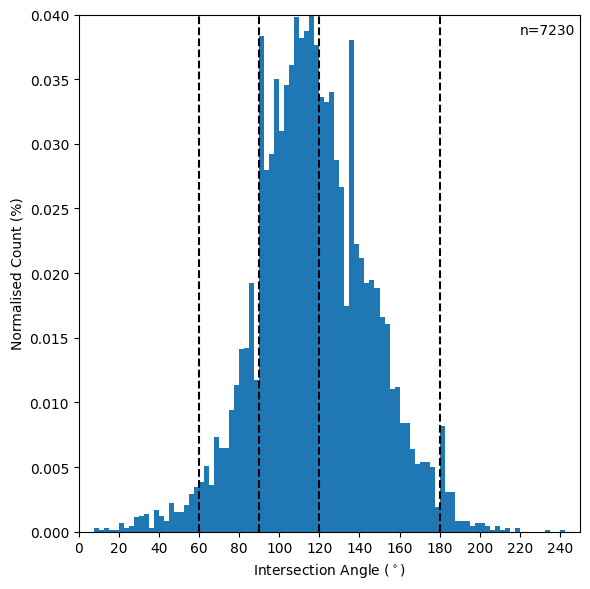

In [122]:
# histogram of intersection angles:
fig,ax = plt.subplots(1,1,figsize=(6,6),layout='tight')

ax.hist(intersection_angles,bins=100,weights=np.ones(len(intersection_angles)) / len(intersection_angles),range=(0,250),align='mid')

ax.set_xticks(np.arange(0,250,20))
ax.set_ylim(0,0.04)
ax.set_xlim(0,250)
ax.vlines([60,90,120,180],0,1,colors='black',linestyles='dashed')
ax.text(220,0.0385,f'n={len(intersection_angles)}')

ax.set_xlabel('Intersection Angle ($^\circ$)')
ax.set_ylabel('Normalised Count (%)')

fig.savefig(path_figs+'intersection_histogram.png');

In [123]:
df = pd.DataFrame({'triple':tr,'quadruple': qu,'terminal': terminal,'angles':intersection_angles})
df.to_csv(path_in+'intersections.csv',index=False)